Successfully loaded psd_results_2Hz.csv
Input DataFrame head:
   Label Channel Frequency_Band   Mean_PSD  Variance_PSD
0      1     FC3          4-6Hz -54.576025      7.580901
1      1     FC3          6-8Hz -55.706401      7.308809
2      1     FC3         8-10Hz -54.904120      7.881428
3      1     FC3        10-12Hz -56.272002      8.368424
4      1     FC3        12-14Hz -59.229255      6.290857

Input DataFrame columns:
Index(['Label', 'Channel', 'Frequency_Band', 'Mean_PSD', 'Variance_PSD'], dtype='object')
Fisher ratios saved to 'fisher_ratios.csv'


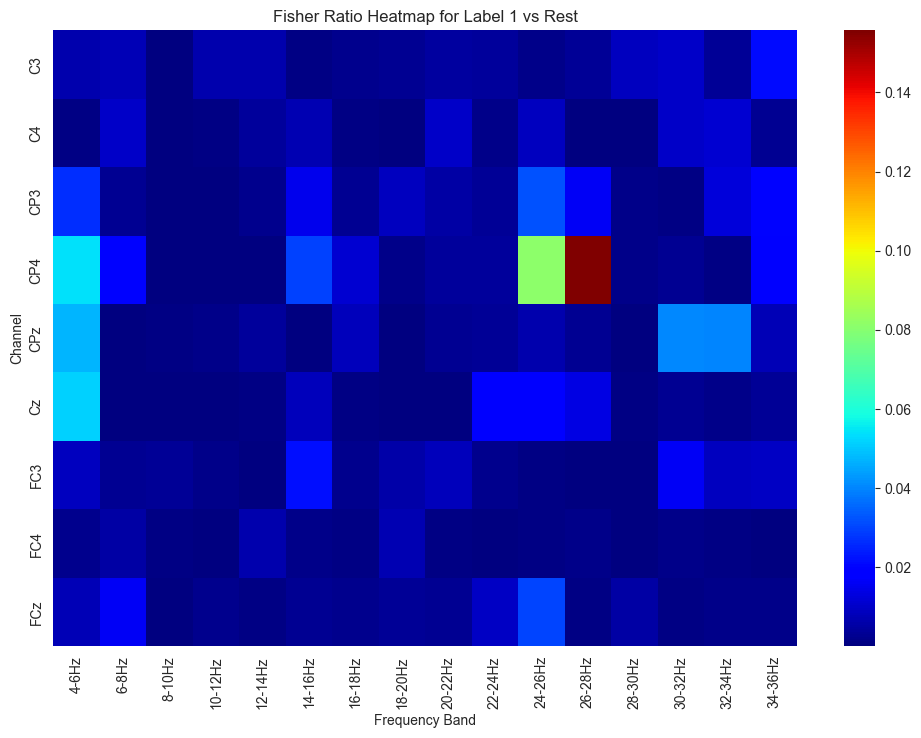

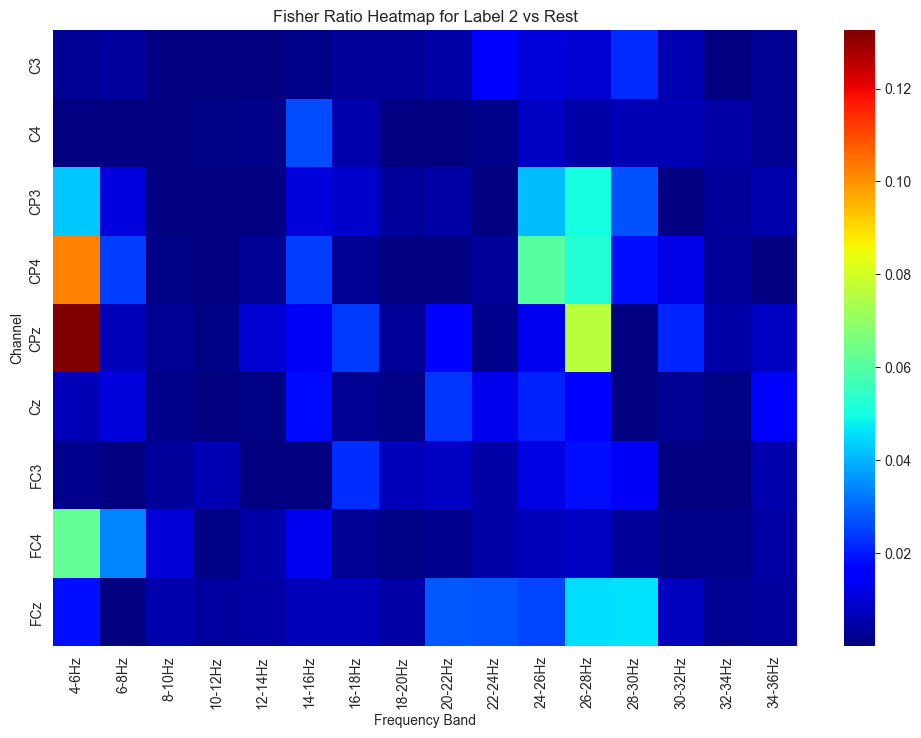

In [5]:
from pandas import read_csv, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
# Make sure 'psd_results_2Hz.csv' is in the same directory as the script, or provide the full path
try:
    df = read_csv('psd_results_2Hz.csv')
    print("Successfully loaded psd_results_2Hz.csv")
    print("Input DataFrame head:")
    print(df.head())
    print("\nInput DataFrame columns:")
    print(df.columns)
except FileNotFoundError:
    print("Error: psd_results_2Hz.csv not found.")
    print("Please ensure 'psd_results_2Hz.csv' is in the correct directory.")
    exit() # Exit the script if the input file is not found

# Function to calculate Fisher Ratios
def calculate_fisher_ratios(df):
    fisher_ratios = []

    target_labels = [1, 2]  # needs fix +++++++++++++++++++++++++++++++++++++++++++++++++
    rest_label = 3  # needs fix ++++++++++++++++++++++++++++++++++++++

    # Check if the required columns exist in the DataFrame
    required_cols = ['Label', 'Channel', 'Frequency_Band', 'Mean_PSD', 'Variance_PSD']
    if not all(col in df.columns for col in required_cols):
        print(f"Error: Input DataFrame must contain the following columns: {required_cols}")
        return DataFrame() # Return empty DataFrame if columns are missing

    for target_label in target_labels:
        # Data for the specific label
        target_data = df[df['Label'] == target_label]
        # Data for the rest label
        rest_data = df[df['Label'] == rest_label]

        if target_data.empty or rest_data.empty:
            print(f"Warning: No data found for target label {target_label} or rest label {rest_label}. Skipping.")
            continue

        for channel in target_data['Channel'].unique():
            for freq_band in target_data['Frequency_Band'].unique():
                # Mean and variance for the specific label (target_label)
                target_row = target_data[(target_data['Channel'] == channel) & (target_data['Frequency_Band'] == freq_band)]
                rest_row = rest_data[(rest_data['Channel'] == channel) & (rest_data['Frequency_Band'] == freq_band)]

                if not target_row.empty and not rest_row.empty:
                    target_mean = target_row['Mean_PSD'].values[0]
                    target_variance = target_row['Variance_PSD'].values[0]

                    rest_mean = rest_row['Mean_PSD'].values[0]
                    rest_variance = rest_row['Variance_PSD'].values[0]

                    # Calculate Fisher Ratio
                    # Added a check to avoid division by zero or near-zero values
                    denominator = (rest_variance ** 2) + (target_variance ** 2)
                    if denominator != 0:
                         fisher_ratio = (rest_mean - target_mean) ** 2 / denominator
                    else:
                         fisher_ratio = np.inf # Assign infinity if denominator is zero

                    fisher_ratios.append({
                        'Label': target_label,
                        'Channel': channel,
                        'Frequency_Band': freq_band,
                        'Fisher_Ratio': fisher_ratio
                    })
                else:
                    # print(f"Warning: Data not found for Channel {channel}, Frequency Band {freq_band} for either target label {target_label} or rest label {rest_label}. Skipping Fisher Ratio calculation for this combination.")
                    pass # Suppress excessive warnings, can uncomment for debugging


    fisher_df = DataFrame(fisher_ratios)

    # Check if fisher_df is empty before sorting
    if fisher_df.empty:
        print("No Fisher Ratios were calculated. This might be due to missing data for labels, channels, or frequency bands.")
        return fisher_df # Return the empty DataFrame

    # Sort the DataFrame by Fisher Ratio in descending order for each Label
    # Ensure the 'Label' column exists before sorting
    if 'Label' in fisher_df.columns and 'Fisher_Ratio' in fisher_df.columns:
        fisher_df = fisher_df.sort_values(by=['Label', 'Fisher_Ratio'], ascending=[True, False])
    else:
        print("Error: 'Label' or 'Fisher_Ratio' column not found in the calculated Fisher Ratio DataFrame. Cannot sort.")


    return fisher_df

# Calculate Fisher Ratios
fisher_df = calculate_fisher_ratios(df)

# Check if fisher_df is empty before saving and plotting
if not fisher_df.empty:
    # Save the Fisher Ratios result to a CSV file
    fisher_df.to_csv('fisher_ratios.csv', index=False)
    print("Fisher ratios saved to 'fisher_ratios.csv'")

    # Function to plot Fisher Ratio heatmaps
    def plot_fisher_ratios(fisher_df):
        labels = fisher_df['Label'].unique()

        # Define the desired frequency band order - Make sure these bands exist in your data
        frequency_band_order = ['4-6Hz', '6-8Hz', '8-10Hz', '10-12Hz', '12-14Hz', '14-16Hz',
                                '16-18Hz', '18-20Hz', '20-22Hz', '22-24Hz', '24-26Hz', '26-28Hz',
                                '28-30Hz', '30-32Hz', '32-34Hz', '34-36Hz']

        for label in labels:
            label_fisher_df = fisher_df[fisher_df['Label'] == label]

            # Pivot table with the specified frequency band order
            # Ensure all frequency bands in frequency_band_order are in the DataFrame before pivoting
            present_frequency_bands = label_fisher_df['Frequency_Band'].unique()
            valid_frequency_band_order = [band for band in frequency_band_order if band in present_frequency_bands]


            if not label_fisher_df.empty and valid_frequency_band_order:
                pivot_table = label_fisher_df.pivot_table(index='Channel', columns='Frequency_Band', values='Fisher_Ratio')
                # Reindex columns to ensure correct order, filling missing bands with NaN
                pivot_table = pivot_table.reindex(columns=valid_frequency_band_order)


                plt.figure(figsize=(12, 8))
                sns.heatmap(pivot_table, cmap='jet', annot=False)
                plt.title(f'Fisher Ratio Heatmap for Label {label} vs Rest')
                plt.xlabel('Frequency Band')
                plt.ylabel('Channel')
                plt.show()
            elif not valid_frequency_band_order:
                print(f"Warning: No valid frequency bands found for label {label} based on the defined order. Cannot plot heatmap.")
            else:
                 print(f"Warning: No data to plot heatmap for label {label}.")


    # Plot Fisher Ratio heatmaps
    plot_fisher_ratios(fisher_df)
else:
    print("Skipping saving and plotting as no Fisher Ratios were calculated.")